In [17]:
import pandas as pd
from tqdm import tqdm

In [18]:
import random

def random_model(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["logit_0"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    df["logit_1"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    return df

In [19]:
df = pd.read_pickle("../results/predictions_finetuned_2e-5_bs32_e3_best.pkl")
# df = random_model(df)
print(len(df))
df.head()


1532682


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1
0,riehl_ovidhofe.json,0,1,1,-3.513684,2.484013
1,riehl_ovidhofe.json,0,2,1,-4.145504,2.869292
2,riehl_ovidhofe.json,0,3,1,-1.776233,1.367002
3,riehl_ovidhofe.json,0,4,1,-4.529003,3.121587
4,riehl_ovidhofe.json,0,5,1,-3.214940,2.548427


In [20]:
print(df["book_path"].sort_values().unique())

['about_bergkoen.json' 'about_parisehe.json' 'abraham_fabeln.json' ...
 'zschokke_hansdmpf.json' 'zschokke_narr19.json' 'zschokke_neujahrs.json']


In [21]:
predicted_chapter_counts = pd.read_pickle("../test_predicted_chapter_counts.pkl")
print(predicted_chapter_counts.head())

                book_path  chapter_count  metrics_prediction  \
0     about_bergkoen.json             10           23.586574   
1     about_parisehe.json             13           20.850396   
2     abraham_fabeln.json              5            9.046316   
3   abraham_narrnest.json             12           11.883909   
4  achleitn_bezirks1.json              5           16.067736   

   novel_metrics_prediction  confidences_prediction  \
0                 20.575634               19.278949   
1                 18.902229               17.377221   
2                  7.265612                8.695430   
3                  9.902353               13.220007   
4                 14.465906               13.105857   

   novel_confidences_prediction  
0                     18.040357  
1                     16.139760  
2                      5.574391  
3                     10.686268  
4                     11.295539  


In [22]:
stats_df = pd.read_pickle("../per_chapter_test_split_stats.pkl")
print(stats_df.head())

   paragraph_count  word_count  sentence_count               book_path  \
0             1059       70700            4205     about_bergkoen.json   
0             1287       64018            3178     about_parisehe.json   
0               15        1011              36     abraham_fabeln.json   
0               80       13506             391   abraham_narrnest.json   
0             1171       42926            2548  achleitn_bezirks1.json   

   chapter_count  
0             10  
0             13  
0              5  
0             12  
0              5  


In [23]:
def predict_top_n(logit_0: pd.Series, break_count):
    threshold_value = logit_0.sort_values(ascending=False).values[min(round(break_count), len(logit_0) - 1)]
    return [l <= threshold_value for l in logit_0.values]

def add_predictions(df: pd.DataFrame) -> pd.DataFrame:
    predicted_chapter_counts = pd.read_pickle("../test_predicted_chapter_counts.pkl")

    books = []
    for book_path, group in df.groupby(["book_path"]):
        local_predictions = group["logit_0"] < group["logit_1"]
        normalized = (group["logit_0"] - group["logit_0"].min())/(group["logit_0"].max() - group["logit_0"].min())
        local_threshold_predictions = [l <= 0.9 for l in normalized]
        gt_chapter_break_count = group["chapter_idx"].max()
        pred = predicted_chapter_counts[predicted_chapter_counts["book_path"] == book_path]
        if len(pred) == 0:
            print(book_path)
            continue
        metrics = pred["metrics_prediction"].values[0]
        metrics_novel = pred["novel_metrics_prediction"].values[0]
        confidences = pred["confidences_prediction"].values[0]
        confidences_novel = pred["novel_confidences_prediction"].values[0]
        new_df = group.reset_index()
        new_df["local_prediction"] = local_predictions.values
        new_df["local_threshold_prediction"] = local_threshold_predictions
        new_df["top_n_prediction"] = predict_top_n(group["logit_0"], gt_chapter_break_count)
        new_df["metrics_prediction"] = predict_top_n(group["logit_0"], metrics)
        new_df["metrics_novel_prediction"] = predict_top_n(group["logit_0"], metrics_novel)
        new_df["confidences_prediction"] = predict_top_n(group["logit_0"], confidences)
        new_df["confidences_novel_prediction"] = predict_top_n(group["logit_0"], confidences_novel)
        books.append(new_df)

    return pd.concat(books)

pred_df = add_predictions(df)
pred_df.head()

,index,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1,local_prediction,local_threshold_prediction,top_n_prediction,metrics_prediction,metrics_novel_prediction,confidences_prediction,confidences_novel_prediction
0,832428,about_bergkoen.json,0,1,1,-4.835626,3.190730,True,True,True,True,True,True,True
1,832429,about_bergkoen.json,0,2,1,-4.390160,2.838304,True,True,True,True,True,True,True
2,832430,about_bergkoen.json,0,3,1,-2.330351,1.519239,True,True,True,True,True,True,True
3,832431,about_bergkoen.json,0,4,1,-0.165553,-0.013407,True,True,True,True,True,True,True
4,832432,about_bergkoen.json,0,5,1,-3.427582,1.863970,True,True,True,True,True,True,True


In [24]:
import json
from sklearn.metrics import f1_score
from nltk.metrics import segmentation

def calc_f1_score(df: pd.DataFrame, prediction_column: str) -> float:
    # class 0 (chapter break) is relevant for us
    return f1_score(
        df["labels"].replace([1, 0], value=[False, True]),
        df[prediction_column].replace([True, False], value=[False, True]),
    )


def calc_pk_wd(df: pd.DataFrame, prediction_column: str) -> tuple:
    # class 0 (no continuation) should denote chapter break, metrics assume 1
    labels = df["labels"].replace([1, 0], value=[0, 1])
    predictions = df[prediction_column].replace([True, False], value=[0, 1])
    labels = "".join(map(str, labels))
    predictions = "".join(map(str, predictions))
    # k should be half average reference segment length
    # average paragraph count per chapter is ~54
    # median is 32
    k = int(round(len(labels) / (labels.count("1") * 2.0)))
    pk = segmentation.pk(labels, predictions, k=k)
    windowdiff = segmentation.windowdiff(labels, predictions, k=k)
    return pk, windowdiff

def calculate_metrics(df: pd.DataFrame, prediction_column: str) -> pd.DataFrame:
    results = []
    for book, group in tqdm(df.groupby(["book_path"])):
        f1 = calc_f1_score(group, prediction_column)
        pk, windowdiff = calc_pk_wd(group, prediction_column)
        with open(f"../corpus/{book}", "r") as f:
            genre = json.load(f)["genre"]
        results.append({"book": book, "f1": f1, "pk": pk, "wd": windowdiff, "genre": genre})
    return pd.DataFrame(results)

In [25]:
top_n_df = calculate_metrics(pred_df, "top_n_prediction")

print("Micro-averaged F1: ", top_n_df["f1"].mean())
print("Micro-averaged PK: ", top_n_df["pk"].mean())
print("Micro-averaged WD: ", top_n_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 224.20it/s]

Micro-averaged F1:  0.5065198809267434
Micro-averaged PK:  0.2706797114213102
Micro-averaged WD:  0.3304795577521118


In [26]:
genre_grouped = top_n_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="f1", ascending=False)

,f1,pk,wd,count
genre,,,,
Anthologien,0.758333,0.133945,0.182381,2
"Märchen, Sagen, Legenden",0.735751,0.145684,0.190550,52
"Humor, Satire",0.636897,0.177778,0.245307,40
Historische Kriminalromane und -fälle,0.609882,0.181452,0.274888,5
Kinderbücher ab 12 Jahren,0.566549,0.263613,0.320694,42
Science Fiction,0.497260,0.277691,0.326161,7
"Romane, Novellen und Erzählungen",0.490428,0.276445,0.337424,852
"Krimis, Thriller, Spionage",0.485029,0.304755,0.359000,71
Historische Romane und Erzählungen,0.484475,0.291250,0.349775,65


In [27]:
local_df = calculate_metrics(pred_df, "local_prediction")

print("Micro-averaged F1: ", local_df["f1"].mean())
print("Micro-averaged PK: ", local_df["pk"].mean())
print("Micro-averaged WD: ", local_df["wd"].mean())

  0%|          | 0/1188 [00:00<?, ?it/s]

100%|██████████| 1188/1188 [00:05<00:00, 227.49it/s]


Micro-averaged F1:  0.26265731936000625
Micro-averaged PK:  0.43404407678190066
Micro-averaged WD:  0.8219959280988905


In [28]:
genre_grouped = local_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.251633,0.438066,0.828459,852
"Krimis, Thriller, Spionage",0.238893,0.436571,0.844860,71
Historische Romane und Erzählungen,0.234289,0.447706,0.872362,65
"Märchen, Sagen, Legenden",0.446305,0.374292,0.664472,52
Kinderbücher ab 12 Jahren,0.284126,0.425316,0.827569,42
"Humor, Satire",0.393671,0.360234,0.669765,40
Spannung und Abenteuer,0.229692,0.450886,0.859735,19
Phantastische Literatur,0.215858,0.472918,0.901665,16
Romanhafte Biographien,0.153052,0.498981,0.942654,13


In [30]:
local_threshold_df = calculate_metrics(pred_df, "local_threshold_prediction")

print("Micro-averaged F1: ", local_threshold_df["f1"].mean())
print("Micro-averaged PK: ", local_threshold_df["pk"].mean())
print("Micro-averaged WD: ", local_threshold_df["wd"].mean())

100%|██████████| 1188/1188 [00:05<00:00, 233.62it/s]


Micro-averaged F1:  0.3915715483961368
Micro-averaged PK:  0.3349133920912719
Micro-averaged WD:  0.37165439162265734


In [31]:
genre_grouped = local_threshold_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.378595,0.339238,0.378507,852
"Krimis, Thriller, Spionage",0.310556,0.406967,0.436870,71
Historische Romane und Erzählungen,0.379471,0.349788,0.376147,65
"Märchen, Sagen, Legenden",0.675583,0.182521,0.218572,52
Kinderbücher ab 12 Jahren,0.433173,0.324671,0.345681,42
"Humor, Satire",0.498574,0.256704,0.290977,40
Spannung und Abenteuer,0.286377,0.419450,0.436814,19
Phantastische Literatur,0.321394,0.360022,0.376739,16
Romanhafte Biographien,0.335756,0.363812,0.426487,13


In [40]:
# metrics_prediction	metrics_novel_prediction	confidences_prediction	confidences_novel_prediction
temp_pred_df = calculate_metrics(pred_df, "confidences_novel_prediction")

print("Micro-averaged F1: ", temp_pred_df["f1"].mean())
print("Micro-averaged PK: ", temp_pred_df["pk"].mean())
print("Micro-averaged WD: ", temp_pred_df["wd"].mean())

genre_grouped = temp_pred_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

100%|██████████| 1188/1188 [00:05<00:00, 227.41it/s]

Micro-averaged F1:  0.4424430180166449
Micro-averaged PK:  0.31245198131091845
Micro-averaged WD:  0.43362426382922553


,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.429019,0.317686,0.444599,852
"Krimis, Thriller, Spionage",0.445783,0.335067,0.447898,71
Historische Romane und Erzählungen,0.444456,0.313904,0.431638,65
"Märchen, Sagen, Legenden",0.534991,0.267133,0.366561,52
Kinderbücher ab 12 Jahren,0.524259,0.277340,0.363052,42
"Humor, Satire",0.558877,0.223889,0.310010,40
Spannung und Abenteuer,0.401776,0.353024,0.446729,19
Phantastische Literatur,0.396177,0.311323,0.418322,16
Romanhafte Biographien,0.350559,0.371975,0.566113,13


In [32]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_book(dataframe: pd.DataFrame, book_id=None, fig_size=(20, 5), column="top_n_prediction"):
    f = open("output_file.txt", "w")
    book_id = book_id
    if book_id == None:
        book_id = random.choice(dataframe["book_path"])
    f.write(book_id + "\n")
    f.write(column + "\n")
    book_df = dataframe[dataframe["book_path"] == book_id]
    book_df.index = [i - min(book_df.index) for i in book_df.index]

    if column == "log_prediction":
        normalized_logit_0 = (book_df["logit_0"] - book_df["logit_0"].min())/(book_df["logit_0"].max() - book_df["logit_0"].min())
        indices = np.where(np.array(normalized_logit_0) > 0.9)[0]
        candidates = book_df.iloc[indices]
    else:
      candidates = book_df[book_df[column] == False]

    plt.figure(figsize=fig_size)
    plt.title(f"BERT-predicted chapter breaks - {book_id}")
    plt.xlabel("Paragraph")
    plt.ylabel("BERT confidence score")
    if column == "log_prediction":
        plt.scatter(book_df.index, normalized_logit_0, s=5)
        plt.scatter(candidates.index, np.array(normalized_logit_0)[indices], c="red", marker="s")
    else:
        plt.scatter(book_df.index, book_df["logit_0"], s=5)
        plt.scatter(candidates.index, candidates["logit_0"], c="red", marker="s")
    f.write("Confidences\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in book_df.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in book_df["logit_0"]])
    f.write("Candidates\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in candidates.index])
    f.write("Y\n")
    f.writelines([str(v) + "\n" for v in candidates["logit_0"]])
    xcoords = book_df[book_df["labels"] == 0].index
    f.write("Breaks\n")
    f.write("X\n")
    f.writelines([str(v) + "\n" for v in xcoords])
    for x in xcoords:
        plt.axvline(x, c="green")
    f.close()
    plt.show()

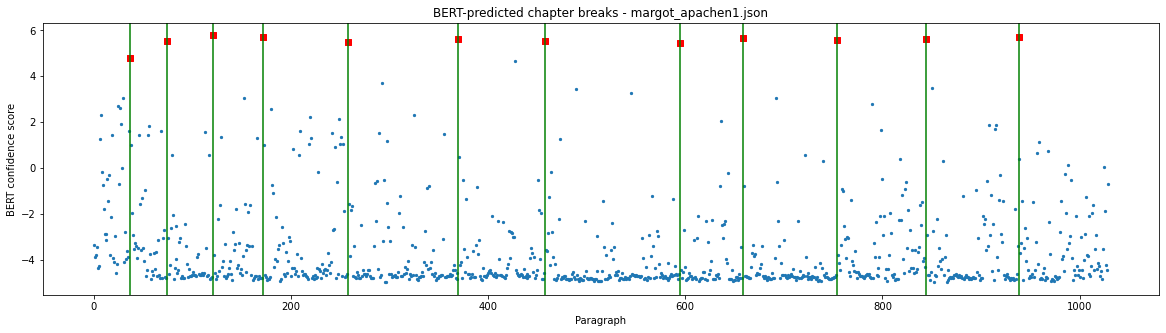

In [33]:
# potentially interesting examples:
# * margot_apachen1.json (perfect prediction)
# * may_baerenj.json (clustered predictions with peaks on chapter breaks)
# * lagerloe_christus.json (anthology w/ some multi-chapter stories inside)
plot_book(pred_df, "margot_apachen1.json", column="top_n_prediction")

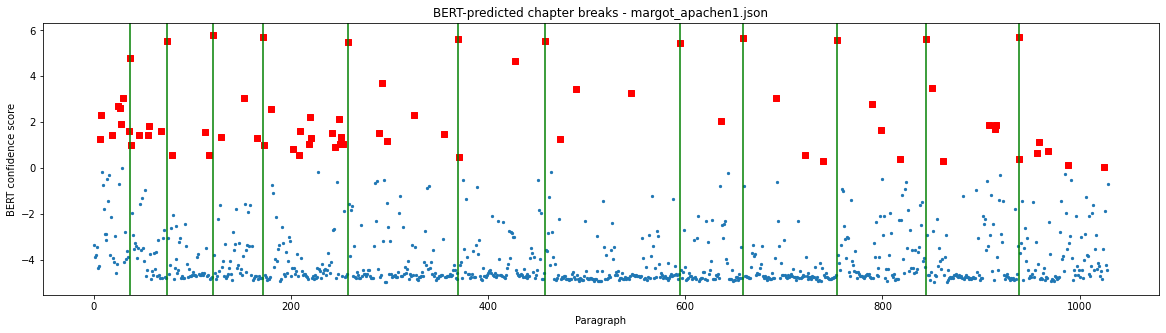

In [34]:
plot_book(pred_df, "margot_apachen1.json", column="local_prediction")

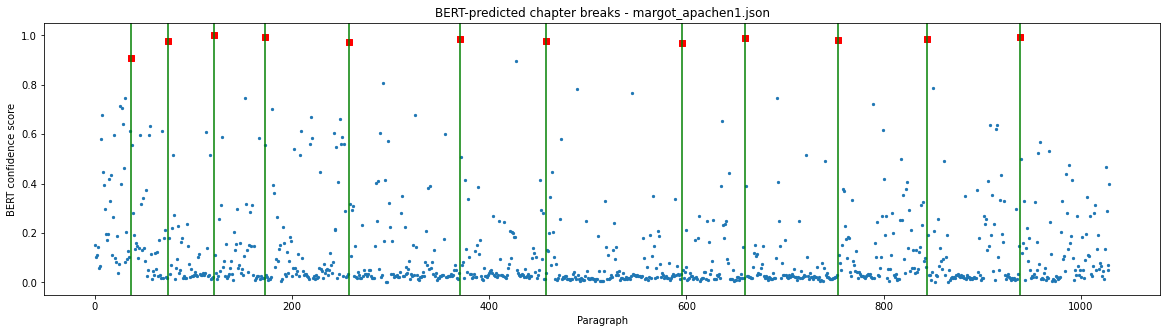

In [35]:
plot_book(pred_df, "margot_apachen1.json", column="log_prediction")

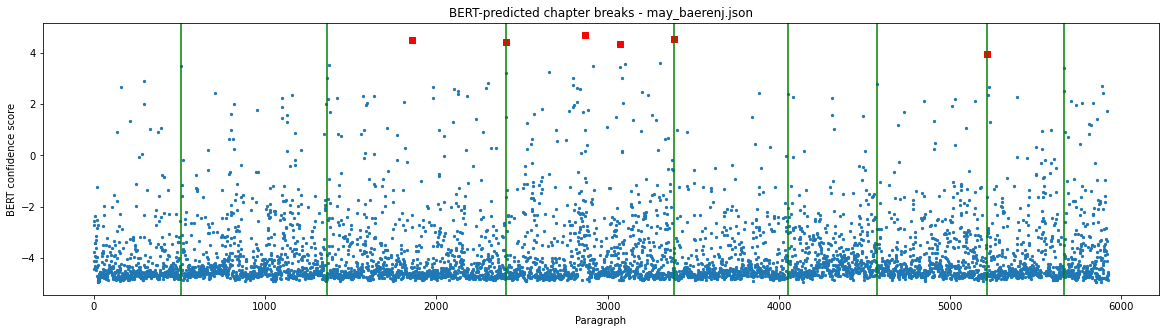

In [ ]:
plot_book(pred_df, "may_baerenj.json", column="local_threshold_prediction")